In [2]:
# Step 1: Load Data and Packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords


In [3]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ltlid\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# Loding csv file
df = pd.read_csv("../data/raw_analyst_ratings.csv")

In [5]:
# Drop unnamed index column if exists
df = df.drop(columns=["Unnamed: 0"], errors="ignore")

In [6]:
# Convert date to datetime
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.dropna(subset=["date"])

count    55987.000000
mean        80.015254
std         56.126094
min         12.000000
25%         42.000000
50%         63.000000
75%         91.000000
max        512.000000
Name: headline_length, dtype: float64


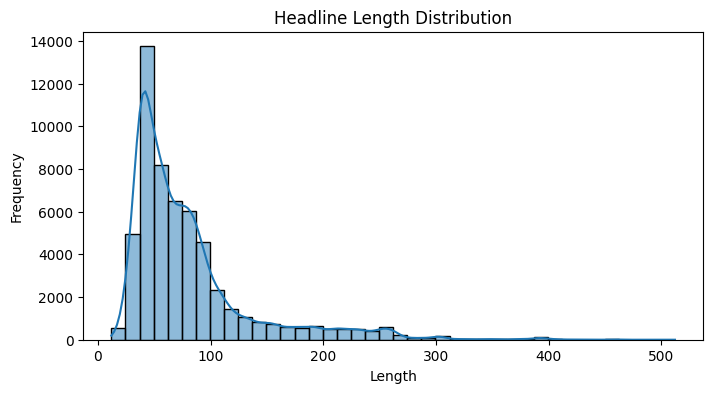

In [7]:
# Step 2: Descriptive Statistics - Headline Length
df["headline_length"] = df["headline"].astype(str).apply(len)
print(df["headline_length"].describe())

plt.figure(figsize=(8, 4))
sns.histplot(df["headline_length"], bins=40, kde=True)
plt.title("Headline Length Distribution")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.show()

publisher
Benzinga Newsdesk    14750
Lisa Levin           12408
ETF Professor         4362
Paul Quintaro         4212
Benzinga Newsdesk     3177
Name: count, dtype: int64


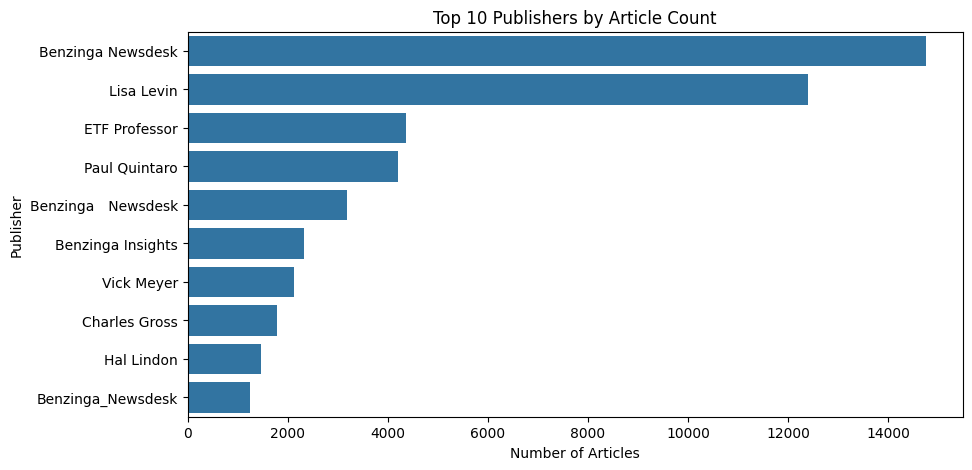

In [8]:
# Step 3: Publisher Counts
publisher_counts = df["publisher"].value_counts()
print(publisher_counts.head())

plt.figure(figsize=(10, 5))
sns.barplot(x=publisher_counts.head(10).values, y=publisher_counts.head(10).index)
plt.title("Top 10 Publishers by Article Count")
plt.xlabel("Number of Articles")
plt.ylabel("Publisher")
plt.show()

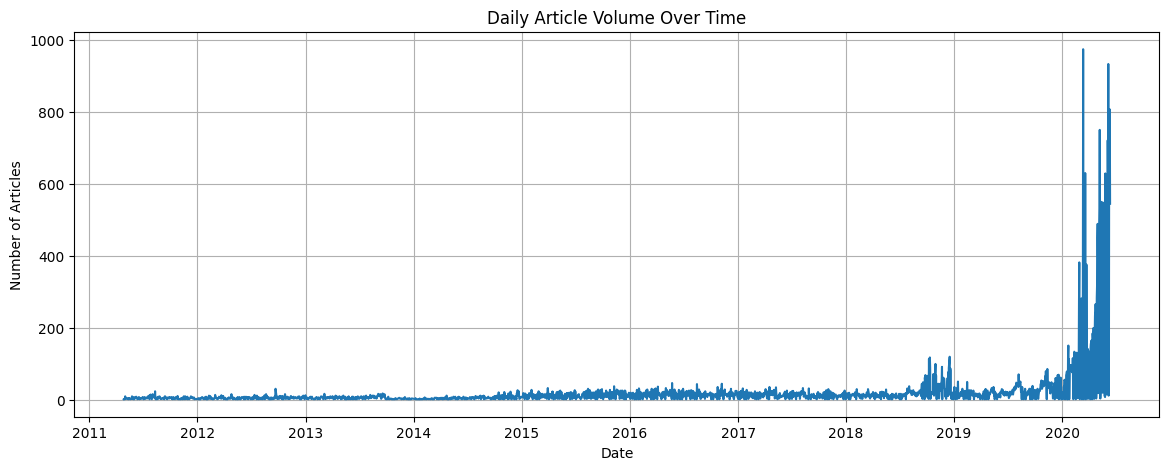

In [9]:
# Step 4: Articles Over Time
daily_counts = df["date"].dt.date.value_counts().sort_index()

plt.figure(figsize=(14, 5))
daily_counts.plot()
plt.title("Daily Article Volume Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Articles")
plt.grid(True)
plt.show()

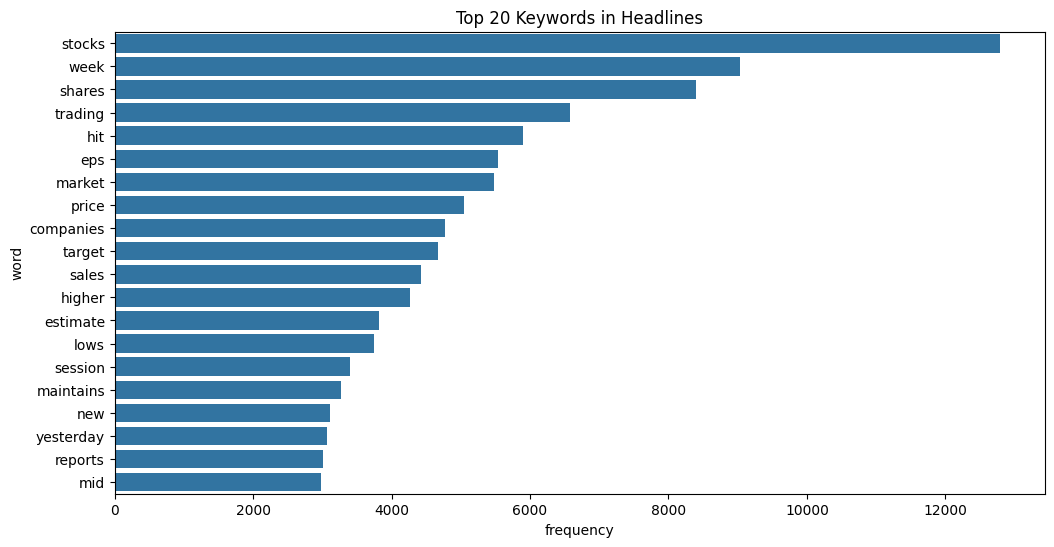

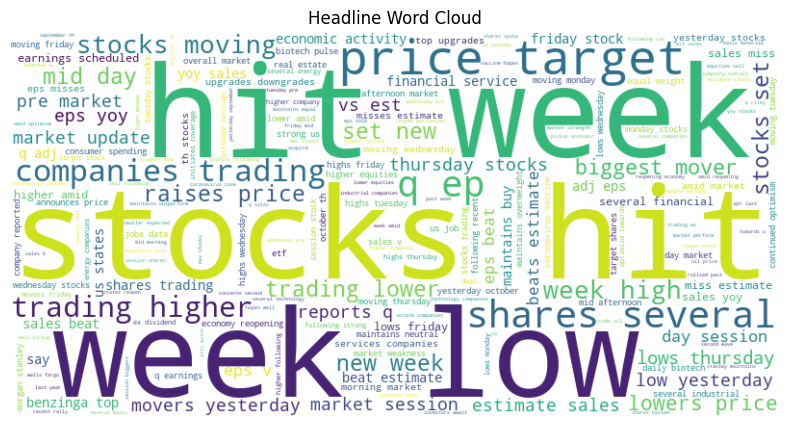

In [10]:
# Step 5: Topic Modeling / Word Frequency
stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-zA-Z\s]", " ", text)
    text = re.sub(r"\s+", " ", text)
    return ' '.join([word for word in text.split() if word not in stop_words])

df["clean_headline"] = df["headline"].apply(clean_text)

vectorizer = CountVectorizer(max_features=100, stop_words='english')
X = vectorizer.fit_transform(df["clean_headline"])
words = vectorizer.get_feature_names_out()
word_freq = X.sum(axis=0).A1

word_df = pd.DataFrame({"word": words, "frequency": word_freq}).sort_values(by="frequency", ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x="frequency", y="word", data=word_df.head(20))
plt.title("Top 20 Keywords in Headlines")
plt.show()

# WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(df["clean_headline"]))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Headline Word Cloud")
plt.show()

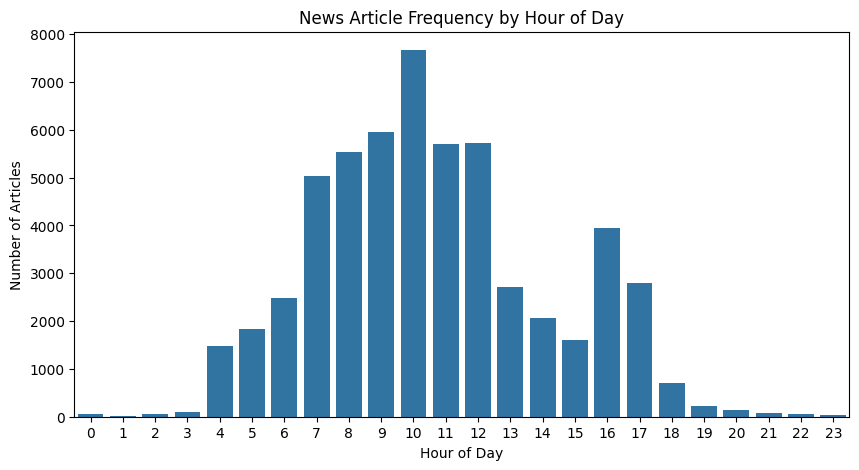

In [11]:
# Step 6: Publishing Time of Day
df["hour"] = df["date"].dt.hour
hourly_counts = df["hour"].value_counts().sort_index()

plt.figure(figsize=(10, 5))
sns.barplot(x=hourly_counts.index, y=hourly_counts.values)
plt.title("News Article Frequency by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Articles")
plt.show()

In [15]:
# # Step 7: Publisher Domain Analysis
# df["email_domain"] = df["publisher"].str.extract(r'@([\\w\\.-]+)')
# domain_counts = df["email_domain"].value_counts().head(10)

# print(domain_counts)

# domain_counts.plot(kind="barh", figsize=(8, 4), title="Top Publisher Email Domains")
# plt.xlabel("Number of Articles")
# plt.show()

Top mentioned stocks:
stock
ZX      10
A       10
AA      10
AAC     10
ZUMZ    10
Name: count, dtype: int64


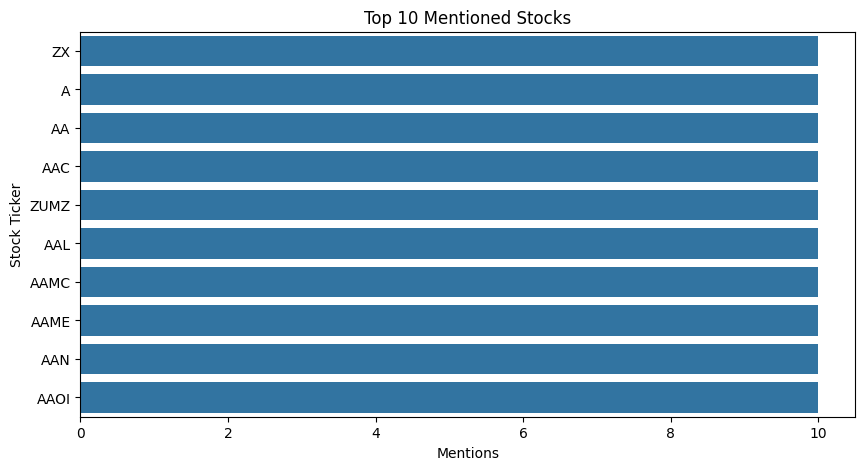

C:\Users\ltlid\AppData\Local\Temp\ipykernel_21956\349910356.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_stocks["date_only"] = df_top_stocks["date"].dt.date


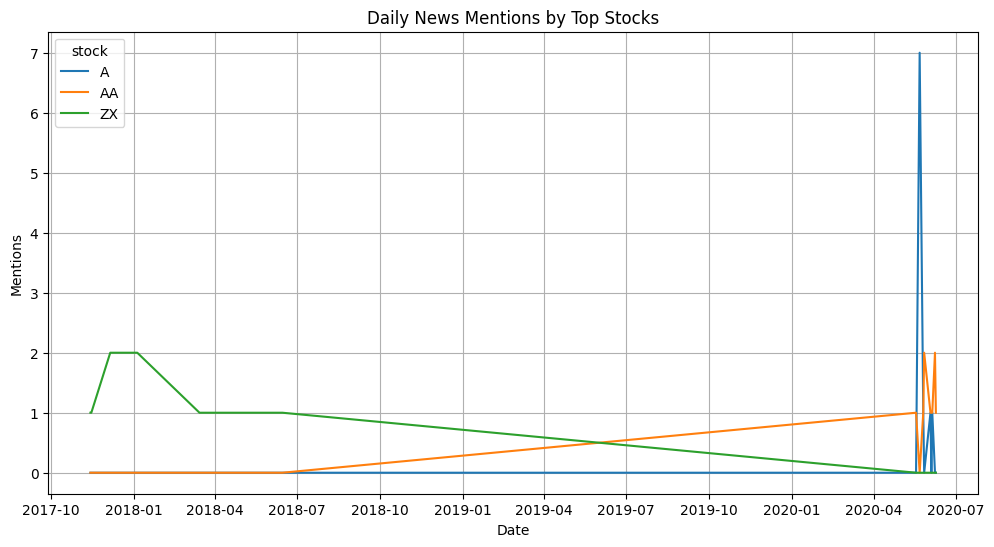

In [14]:
# Step 8: Stock-Specific Analysis
stock_counts = df["stock"].value_counts()
print("Top mentioned stocks:")
print(stock_counts.head())

plt.figure(figsize=(10, 5))
sns.barplot(x=stock_counts.head(10).values, y=stock_counts.head(10).index)
plt.title("Top 10 Mentioned Stocks")
plt.xlabel("Mentions")
plt.ylabel("Stock Ticker")
plt.show()

# Mentions over time (top 3 stocks)
top_stocks = stock_counts.head(3).index
df_top_stocks = df[df["stock"].isin(top_stocks)]

df_top_stocks["date_only"] = df_top_stocks["date"].dt.date
pivot = df_top_stocks.pivot_table(index="date_only", columns="stock", aggfunc="size", fill_value=0)

pivot.plot(figsize=(12, 6), title="Daily News Mentions by Top Stocks")
plt.ylabel("Mentions")
plt.xlabel("Date")
plt.grid(True)
plt.show()